# Guide on how to use the backtester

In [1]:
# Ensure the project root is in PATH.
import sys
sys.path.append(r"C:\Users\Natha\OneDrive\Documents\quant\Statistics\Prosperity\prosperity-crushers")
# All imports of our code are relative to the project root.

from backtester.backtester import Backtester
from backtester.datamodel import TradingState, OrderDepth, Order, Listing

import numpy as np
import pandas as pd
import sys
import os

This is the implementation of our trader - copy paste the trader into this box

In [2]:
import pandas as pd
import numpy as np
class Trader:
    kelp_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss", 'mmbot_bid', 'mmbot_ask','mmbot_midprice', "RSI"
    ])

    resin_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss", 'mmbot_bid', 'mmbot_ask', 'mmbot_midprice', "RSI"
    ])

    squid_ink_df = pd.DataFrame(columns=[
        "timestamp", "product",
        "bid_price_1", "bid_volume_1", "bid_price_2", "bid_volume_2", "bid_price_3", "bid_volume_3",
        "ask_price_1", "ask_volume_1", "ask_price_2", "ask_volume_2", "ask_price_3", "ask_volume_3",
        "mid_price", "profit_and_loss", 'mmbot_bid', 'mmbot_ask', 'mmbot_midprice', "RSI"
    ])
    # “If none of the bots trade on an outstanding player quote, the quote is automatically cancelled at the end of the iteration.”

    def update_df(df, product, state, orders, order_depth):
        buy_orders = sorted(order_depth.buy_orders.items(), key=lambda x: -x[0])
        sell_orders = sorted(order_depth.sell_orders.items(), key=lambda x: x[0])

        bid_levels = buy_orders[:3] + [(None, None)] * (3 - len(buy_orders))
        ask_levels = sell_orders[:3] + [(None, None)] * (3 - len(sell_orders))

        if bid_levels[0][0] is not None and ask_levels[0][0] is not None:
            mid_price = (bid_levels[0][0] + ask_levels[0][0]) / 2
        else:
            mid_price = None

        row = {
            "timestamp": state.timestamp,
            "product": product,
            "bid_price_1": bid_levels[0][0], 
            "bid_volume_1": bid_levels[0][1] or 0,  # If bid_volume_1 is None, set it to 0
            "bid_price_2": bid_levels[1][0], 
            "bid_volume_2": bid_levels[1][1] or 0,  # If bid_volume_2 is None, set it to 0
            "bid_price_3": bid_levels[2][0], 
            "bid_volume_3": bid_levels[2][1] or 0,  # If bid_volume_3 is None, set it to 0
            "ask_price_1": ask_levels[0][0], 
            "ask_volume_1": ask_levels[0][1] or 0,  # If ask_volume_1 is None, set it to 0
            "ask_price_2": ask_levels[1][0], 
            "ask_volume_2": ask_levels[1][1] or 0,  # If ask_volume_2 is None, set it to 0
            "ask_price_3": ask_levels[2][0], 
            "ask_volume_3": ask_levels[2][1] or 0,  # If ask_volume_3 is None, set it to 0
            "mid_price": mid_price,
        }

        
        if row["bid_volume_1"] >= 15: #Adverse volume set to 15. #mm_bot_bid will just become the top level if there is no adverse volume.
            mm_bot_bid = row["bid_price_1"]
        elif row["bid_volume_2"] >= 15:
            mm_bot_bid = row["bid_price_2"]
        elif row["bid_volume_3"] >= 15:
            mm_bot_bid = row["bid_price_3"]
        else:
            mm_bot_bid = row["bid_price_1"]

        if row["ask_volume_1"] >= 15:  # Adverse volume set to 15. mm_bot_ask will just become the top level if there is no adverse volume.
            mm_bot_ask = row["ask_price_1"]
        elif row["ask_volume_2"] >= 15:
            mm_bot_ask = row["ask_price_2"]
        elif row["ask_volume_3"] >= 15:
            mm_bot_ask = row["ask_price_3"]
        else:
            mm_bot_ask = row["ask_price_1"]
        
        row["mmbot_bid"] = mm_bot_bid
        row["mmbot_ask"] = mm_bot_ask
        row["mmbot_midprice"] = (mm_bot_bid + mm_bot_ask) / 2
        
        if len(df) <= 100:
            row["RSI"] = np.nan
        else:
            row["RSI"] = Trader.calculate_most_recent_rsi(df["mid_price"])
                

        df.loc[len(df)] = row

    def __init__(self, retreat_per_lot, edge_per_lot, edge0):
        self.retreat_per_lot = retreat_per_lot
        self.edge_per_lot = edge_per_lot
        self.edge0 = edge0

    def calculate_most_recent_rsi(mid_prices, window=100):
        """
        Calculate the most recent RSI for the last 'window' mid_prices.

        Parameters:
        mid_prices (pd.Series): A pandas Series containing the mid price data.
        window (int): The window size for the RSI calculation, default is 14.

        Returns:
        float: The most recent RSI value.
        """
        # Take the last 'window' number of prices
        recent_prices = mid_prices[-window:]

        # Calculate the price changes for the recent prices
        price_changes = recent_prices.diff()

        # Separate gains and losses
        gains = price_changes.where(price_changes > 0, 0)
        losses = -price_changes.where(price_changes < 0, 0)

        # Calculate the average gains and losses over the window
        avg_gain = gains.mean()
        avg_loss = losses.mean()

        # Handle case where there are no losses (i.e., the stock is only going up)
        if avg_loss == 0:
            return 100  # RSI would be at its maximum (100) if there are no losses.

        # Calculate the Relative Strength (RS)
        rs = avg_gain / avg_loss

        # Calculate RSI
        rsi = (100 - (100 / (1 + rs)))

        return rsi



    def run(self, state: TradingState):
        result = {}
        for product in state.order_depths:
            order_depth: OrderDepth = state.order_depths[product]
            orders: List[Order] = []

            if product == "KELP":
                Trader.update_df(Trader.kelp_df, product, state, orders, order_depth)

            elif product == "RAINFOREST_RESIN":
                Trader.update_df(Trader.resin_df, product, state, orders, order_depth)
            
            elif product == "SQUID_INK":
                Trader.update_df(Trader.squid_ink_df, product, state, orders, order_depth)
                squid_ink_position = state.position.get(product, 0)
                current_row = Trader.squid_ink_df.iloc[-1]
                bid_minus_ask_volume = current_row["bid_volume_1"] + current_row["bid_volume_2"] + current_row["bid_volume_3"] + current_row["ask_volume_1"] + current_row["ask_volume_2"] + current_row["ask_volume_3"]
                if bid_minus_ask_volume >= 15:
                    orders.append(Order(product, current_row["ask_price_1"], 1 - squid_ink_position))
                    print(f"Trading at {current_row['ask_price_1']} with volume {1 - squid_ink_position}")
                    print(f"Bid-Ask Volume Difference: {bid_minus_ask_volume}")
                elif bid_minus_ask_volume <= -15:
                    orders.append(Order(product, current_row["bid_price_1"], -1 - squid_ink_position))
                    print(f"Trading at {current_row['bid_price_1']} with volume {-1 - squid_ink_position}")
                    print(f"Bid-Ask Volume Difference: {bid_minus_ask_volume}")
            result[product] = orders

        return result, 1, "SAMPLE"


Copy paste these below lines whenever you want to access the historical data. These have datatype `pd.Dataframe`.  

If you want all 3 days combined into 1, then copy the code for `market_data_all3days` and `trades_all3days`. You can't just `pd.concat()` them all because the backtester doesn't consider day.

In [3]:
market_data_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_0.csv"), sep=";")
market_data_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-1.csv"), sep=";")
market_data_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "prices_round_1_day_-2.csv"), sep=";")

trades_day_0 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_0.csv"), sep=";")
trades_day_neg1 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-1.csv"), sep=";")
trades_day_neg2 = pd.read_csv(os.path.join("..", "data", "round1", "trades_round_1_day_-2.csv"), sep=";")


# concatenates multiple days of historical data into 1.
# drops day column and replaces it with continuous timestamps.
# i.e. day -1 timestamp 0 becomes just timestamp 1,000,000
def concatenate_historical_data(data: list[pd.DataFrame]) -> pd.DataFrame:
    output = data[0]

    for i in range(1, len(data), 1):
        timeshift = output.iloc[-1]["timestamp"] + 100  # 100 for next day
        next_day_copy = data[i].copy()
        next_day_copy["timestamp"] += timeshift

        output = pd.concat([output, next_day_copy])

    return output

market_data_all3days = concatenate_historical_data([market_data_day_neg2, market_data_day_neg1, market_data_day_0])
trades_all3days = concatenate_historical_data([trades_day_neg2, trades_day_neg1, trades_day_0])

Grid Search

In [4]:
'''
from itertools import product
from joblib import Parallel, delayed
import joblib
from multiprocessing import Manager
from tqdm import tqdm
from contextlib import contextmanager
import traceback

# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
}

# 3. Define fair value evaluation functions.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000

fair_value_evaluator = {
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}

# 4. tqdm-joblib integration
from joblib.parallel import BatchCompletionCallBack, ParallelBackendBase, register_parallel_backend

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    class TqdmParallelBackend(ParallelBackendBase):
        def configure(self, n_jobs=None, parallel=None, **backend_args):
            self.parallel = parallel
            return self

        def effective_n_jobs(self, n_jobs):
            return n_jobs

        def apply_async(self, func, callback=None):
            return func, callback

        def abort_everything(self, ensure_cleanup):
            pass

        def terminate(self):
            pass

    register_parallel_backend('tqdm', TqdmParallelBackend)

    old_callback = BatchCompletionCallBack
    try:
        joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
        yield
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

# 5. Parameter grid
retreat_per_lot_list = [0.002, 0.005, 0.0075, 0.009, 0.01, 0.012, 0.015, 0.02, 0.05]
edge_per_lot_list = [0.002, 0.005, 0.0075, 0.009, 0.01, 0.012, 0.015, 0.02, 0.05]
edge0_list = [0, 0.02, 0.05, 0.1, 0.2, 0.4]
param_grid = list(product(retreat_per_lot_list, edge_per_lot_list, edge0_list))

manager = Manager()
best_so_far = manager.dict({"pnl": float("-inf"), "params": None})

# 6. Run backtest
def run_backtest(retreat, edge, edge0):
    try:
        trader = Trader(retreat, edge, edge0)
        bt = Backtester(
            trader,
            listings,
            position_limit,
            fair_value_evaluator,
            market_data_day_0,
            trades_day_0,
            output_log_filename=None
        )
        bt.run()
        pnl = bt.pnl["KELP"]  # <-- Important change

        if pnl > best_so_far["pnl"]:
            best_so_far["pnl"] = pnl
            best_so_far["params"] = (retreat, edge, edge0)
            print(f"🏆 New Best → PnL={pnl:.2f} with retreat={retreat}, edge={edge}, edge0={edge0}", flush=True)

        return {
            "retreat_per_lot": retreat,
            "edge_per_lot": edge,
            "edge0": edge0,
            "pnl": pnl
        }
    except Exception:
        print(f"❌ Error with retreat={retreat}, edge={edge}, edge0={edge0}:\n{traceback.format_exc()}", flush=True)
        return None

# 7. Run grid search with tqdm
with tqdm_joblib(tqdm(desc="Grid Search", total=len(param_grid))) as _:
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(run_backtest)(r, e, e0) for r, e, e0 in param_grid
    )

# 8. Final results
results = [r for r in results if r is not None]
results = sorted(results, key=lambda x: x["pnl"], reverse=True)

if results:
    best = results[0]
    print("\n🎯 Final Best Parameters:")
    print(f"Retreat={best['retreat_per_lot']}, Edge={best['edge_per_lot']}, Edge0={best['edge0']}, PnL={best['pnl']:.2f}")
else:
    print("\n⚠️ No successful results were returned.")
'''

'\nfrom itertools import product\nfrom joblib import Parallel, delayed\nimport joblib\nfrom multiprocessing import Manager\nfrom tqdm import tqdm\nfrom contextlib import contextmanager\nimport traceback\n\n# 1. Define the listings.\nlistings = {\n    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),\n    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),\n    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),\n}\n\n# 2. Define the position limits.\nposition_limit = {\n    "KELP": 50,\n    "RAINFOREST_RESIN": 50,\n    "SQUID_INK": 50,\n}\n\n# 3. Define fair value evaluation functions.\ndef calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:\n    return 10000\n\nfair_value_evaluator = {\n    "RAINFOREST_RESIN": calc_rainforest_resin_fair,\n}\n\n# 4. tqdm-joblib integration\nfrom joblib.parallel import BatchCompletionCallBack, ParallelBackendBase, register_par

Lets run the backtester

In [5]:
#Optimal params
retreat_per_lot	= 0.012
edge_per_lot = 0.015 
edge0 = 0.02
# 1. Define the listings.
listings = {
    "KELP": Listing(symbol="KELP", product="KELP", denomination="SEASHELLS"),
    "RAINFOREST_RESIN": Listing(symbol="RAINFOREST_RESIN", product="RAINFOREST_RESIN", denomination="SEASHELLS"),
    "SQUID_INK": Listing(symbol="SQUID_INK", product="SQUID_INK", denomination="SEASHELLS"),
}

# 2. Define the position limits.
position_limit = {
    "KELP": 50,
    "RAINFOREST_RESIN": 50,
    "SQUID_INK": 50,
}


# 3. Define fair value evaluation functions. This is used to determine what our PNL is at times throughout execution when our net position is not 0.
def calc_rainforest_resin_fair(order_depth: OrderDepth) -> float:
    return 10000


fair_value_evaluator = {
    # omitting dictionary entries for KELP, SQUID_INK, so that they use default behaviour: fair_price = (best_bid+best_ask)/2
    "RAINFOREST_RESIN": calc_rainforest_resin_fair,
}


# 4. Market data and trade history files.
# These already exist, look at the previous jupyter cell.

# 5. Instantiate trader object

trader = Trader(retreat_per_lot, edge_per_lot, edge0)
bt = Backtester(trader, listings, position_limit, market_data_day_0, trades_day_0, output_log_filename="squinc.log")

bt.run()

bt.pnl


Trading at 1944 with volume 1
Bid-Ask Volume Difference: 19
Trading at 1960 with volume 0
Bid-Ask Volume Difference: 15


KeyboardInterrupt: 

PNL: {'KELP': 0.0, 'RAINFOREST_RESIN': 0, 'SQUID_INK': -9.0}
Midpoint Sharpe: -0.0121
Spreadcrossing Sharpe: -0.0112
Midpoint PnL (bps): -0.00
Spreadcrossing PnL (bps): -0.00


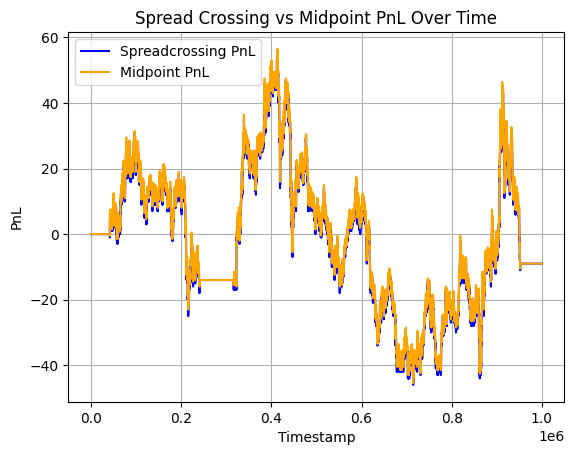

: 

In [ ]:
import matplotlib.pyplot as plt    
product = "SQUID_INK"

resin_metrics = bt.calculate_metrics(product)
print(f"PNL: {bt.pnl}")

print(f"Midpoint Sharpe: {resin_metrics['midpoint_sharpe']:.4f}")
print(f"Spreadcrossing Sharpe: {resin_metrics['spreadcrossing_sharpe']:.4f}")
print(f"Midpoint PnL (bps): {resin_metrics['midpoint_pnl_bps']:.2f}")
print(f"Spreadcrossing PnL (bps): {resin_metrics['spreadcrossing_pnl_bps']:.2f}")

# THIS PART PLOTS SPREADCROSSING_PNL AND MIDPOINT_PNL
spreadcrossing_pnl_history = bt.get_metric("spreadcrossing_pnl", product)
midpoint_pnl_history = bt.get_metric("midpoint_pnl", product)
timestamps = np.unique(bt.market_data["timestamp"])

plt.plot(timestamps, spreadcrossing_pnl_history, label="Spreadcrossing PnL", color="blue")
plt.plot(timestamps, midpoint_pnl_history, label="Midpoint PnL", color="orange")
plt.xlabel("Timestamp")
plt.ylabel("PnL")
plt.title("Spread Crossing vs Midpoint PnL Over Time")
plt.legend()
plt.grid(True)
plt.show()


You can copy paste everything, except for the Trader algo, which should be whatever algo you wish to backtest.